In [104]:
import numpy as np
import pandas as pd
from scipy.stats.mstats import winsorize
from sklearn.linear_model import Lasso,LassoCV,LassoLarsCV
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

from sklearn import svm
from sklearn.tree import DecisionTreeClassifier,plot_tree
import pickle
import os
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from scipy.stats.mstats import winsorize
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV 
from sklearn.preprocessing import StandardScaler

# Load data

In [58]:
def load_data(path):
    df_train = pd.read_csv(f'{path}/cs-training.csv',index_col=0)
    df_test = pd.read_csv(f'{path}/cs-test.csv',index_col=0)
    df_subm = pd.read_csv(f'{path}/sampleEntry.csv',index_col=0)
    df_describe = pd.read_excel(f'{path}/Data Dictionary.xls',header=1)
    return df_train, df_test, df_subm, df_describe

In [59]:
df_train, df_test, df_subm, df_describe = load_data(path='../data')

In [60]:
df_describe

,Variable Name,Description,Type
0,SeriousDlqin2yrs,Person experienced 90 days past due delinquenc...,Y/N
1,RevolvingUtilizationOfUnsecuredLines,Total balance on credit cards and personal lin...,percentage
2,age,Age of borrower in years,integer
3,NumberOfTime30-59DaysPastDueNotWorse,Number of times borrower has been 30-59 days p...,integer
4,DebtRatio,"Monthly debt payments, alimony,living costs di...",percentage
5,MonthlyIncome,Monthly income,real
6,NumberOfOpenCreditLinesAndLoans,Number of Open loans (installment like car loa...,integer
7,NumberOfTimes90DaysLate,Number of times borrower has been 90 days or m...,integer
8,NumberRealEstateLoansOrLines,Number of mortgage and real estate loans inclu...,integer
9,NumberOfTime60-89DaysPastDueNotWorse,Number of times borrower has been 60-89 days p...,integer


In [61]:
df_train.describe()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,1.202690e+05,150000.000000,150000.000000,150000.000000,150000.000000,146076.000000
mean,0.066840,6.048438,52.295207,0.421033,353.005076,6.670221e+03,8.452760,0.265973,1.018240,0.240387,0.757222
std,0.249746,249.755371,14.771866,4.192781,2037.818523,1.438467e+04,5.145951,4.169304,1.129771,4.155179,1.115086
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.029867,41.000000,0.000000,0.175074,3.400000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.154181,52.000000,0.000000,0.366508,5.400000e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,0.000000,0.559046,63.000000,0.000000,0.868254,8.249000e+03,11.000000,0.000000,2.000000,0.000000,1.000000
max,1.000000,50708.000000,109.000000,98.000000,329664.000000,3.008750e+06,58.000000,98.000000,54.000000,98.000000,20.000000


# Feature Engineer

## Combine data

In [62]:
# set features and label
label = df_describe.loc[0,'Variable Name']
features = df_describe.loc[1:,'Variable Name'].to_list()

In [63]:
# set flag to classify train data and test data
df_train['istest'] = 0
df_test['istest'] = 1

In [64]:
# combine train data and test data, and process it
df_raw = pd.concat([df_train,df_test],axis=0)

In [65]:
df_raw[features] = df_raw[features].fillna(0)

## Winsorize Outlier

In [66]:
for feat in features:
    df_raw[feat] = winsorize(df_raw[feat],limits=[0.01,0.01])

## Normalized Feature

In [67]:
scaler = StandardScaler()
df_raw.loc[df_raw['istest']==0,features] = scaler.fit_transform(df_raw.loc[df_raw['istest']==0,features])
df_raw.loc[df_raw['istest']==1,features] = scaler.fit_transform(df_raw.loc[df_raw['istest']==1,features])

## PCA

In [68]:
pca = PCA(n_components = 3)
pca.fit(df_raw[features])

PCA(n_components=3)

In [69]:
df = pd.DataFrame(columns=['feature1','feature2','feature3'])

In [70]:
df[['feature1','feature2','feature3']]=pca.transform(df_raw[features])
df[label] = df_raw[label].values
df['istest'] = df_raw['istest'].values

# Grid Search Parameters

In [88]:
x_train = df.loc[df['istest']==0,['feature1','feature2','feature3']].values
y_train = df.loc[df['istest']==0,label].values

## Grid Search max_depth and min_child_weight

In [100]:
param_test1 = {
'max_depth':[i for i in range(3,10,2)],
'min_child_weight':[i for i in range(1,6,2)]
}

gsearch1 = GridSearchCV(
    estimator = XGBClassifier(

        n_estimators=100, 
        max_depth=5,
        min_child_weight=1,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric='auc',
        seed=27,
        use_label_encoder=False,
#         verbose=10
        
    ),
    param_grid = param_test1,
    scoring='roc_auc',
    cv=5
)
gsearch1.fit(x_train,y_train)
print('max_depth_min_child_weight')
print('gsearch1.best_params_', gsearch1.best_params_)
print('gsearch1.best_score_', gsearch1.best_score_)

max_depth_min_child_weight
gsearch1.best_params_ {'max_depth': 3, 'min_child_weight': 5}
gsearch1.best_score_ 0.8550479964995423


## Grid Search gamma

In [102]:
param_test2 = {
 'gamma':[i/10.0 for i in range(0,5)]
}

gsearch2 = GridSearchCV(
    estimator = XGBClassifier(

        n_estimators=100, 
        max_depth=3,
        min_child_weight=5,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric='auc',
        seed=27,
        use_label_encoder=False,
#         verbose=10
        
    ),
    param_grid = param_test2,
    scoring='roc_auc',
    cv=5
)
gsearch2.fit(x_train,y_train)
print('max_depth_min_child_weight')
print('gsearch1.best_params_', gsearch2.best_params_)
print('gsearch1.best_score_', gsearch2.best_score_)

max_depth_min_child_weight
gsearch1.best_params_ {'gamma': 0.0}
gsearch1.best_score_ 0.8550479964995423


## Grid Search gamma

In [103]:
param_test3 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}

gsearch3 = GridSearchCV(
    estimator = XGBClassifier(

        n_estimators=100, 
        max_depth=3,
        min_child_weight=5,
        gamma=0,
        subsample=0.7,
        colsample_bytree=0.7,
        eval_metric='auc',
        seed=27,
        use_label_encoder=False,
#         verbose=10
        
    ),
    param_grid = param_test3,
    scoring='roc_auc',
    cv=5
)
gsearch3.fit(x_train,y_train)
print('max_depth_min_child_weight')
print('gsearch1.best_params_', gsearch3.best_params_)
print('gsearch1.best_score_', gsearch3.best_score_)

max_depth_min_child_weight
gsearch1.best_params_ {'colsample_bytree': 0.7, 'subsample': 0.7}
gsearch1.best_score_ 0.8551350470697304


# Train Model

In [113]:
def valid_metric(Model,Model_name,x_valid,y_valid,i):
    y_pred = Model.predict_proba(x_valid)[:,1]
#     df = pd.DataFrame({'pred':y_pred,'label':y_valid})
    
    auc_val = roc_auc_score(y_valid, y_pred)
    print(f'fold{i+1}: {Model_name} vaild AUC {round(auc_val,4)}')

def save_model(Model,Model_name,i,path):
    os.makedirs(path,exist_ok=True)
    with open(f'{path}/{Model_name}_{i}.pkl','wb') as f:
        pickle.dump(Model,f)

def load_model(Model_name,i,path):
    with open(f'{path}/{Model_name}_{i}.pkl','rb') as f:
        model = pickle.load(f)
    return model 
    

In [114]:
# kfolds cross validation
kfolds = KFold(n_splits=5, shuffle=False)
train_data = df[df['istest']==0]
train_data = train_data.reset_index().drop('index',axis=1)

# LR_Model_list = []
# SVM_Model_list = []
# Tree_Model_list = []

for i,(train_idx, val_idx) in enumerate(kfolds.split(train_data)):
    # Split train and valid
    x_train = train_data.loc[train_idx,['feature1','feature2','feature3']].values
    y_train = train_data.loc[train_idx,label].values
    
    x_valid = train_data.loc[val_idx,['feature1','feature2','feature3']].values
    y_valid = train_data.loc[val_idx,label].values
    
    xgb = XGBClassifier(
        n_estimators=100, 
        max_depth=3,
        min_child_weight=5,
        gamma=0,
        subsample=0.7,
        colsample_bytree=0.7,
        eval_metric='auc',
        seed=27,
        use_label_encoder=False,
        
    )
    
    xgb.fit(x_train,y_train,eval_set=[(x_valid,y_valid)], eval_metric=["auc"],early_stopping_rounds=10,verbose=10)
    
    y_pred = xgb.predict(x_valid)
    
    accuracy = accuracy_score(y_valid, y_pred)
    print("Accuracy: %.2f%%" % (accuracy * 100.0))
    
    save_model(xgb,'xgboost',i+1,path='./saved_model') # save model
    

    
    
    # Logistic Model
#     LR_Model = LogisticRegression()
#     LR_Model.fit(x_train, y_train)
#     save_model(LR_Model,'LogisticRegression',i+1,path='./saved_model') # save model
    
#     valid_metric(Model=LR_Model,Model_name='LogisticRegression',x_valid=x_valid,y_valid=y_valid,i=i)
    
    
#     # SVM Model
#     SVM_Model = svm.SVC(kernel = 'linear',probability=True)
#     SVM_Model.fit(x_train, y_train)
#     save_model(SVM_Model,'SVM',i+1,path='./saved_model') # save model
    
#     valid_metric(Model=SVM_Model,Model_name='SVM',x_valid=x_valid,y_valid=y_valid,i=i)
    

#     # Tree Model
#     DecisonTree_Model = DecisionTreeClassifier(min_samples_leaf=10)
#     DecisonTree_Model.fit(x_train, y_train)
    
#     save_model(DecisonTree_Model,'DecisionTree',i+1,path='./saved_model') # save model
    
#     valid_metric(Model=DecisonTree_Model,Model_name='DecisionTree',x_valid=x_valid,y_valid=y_valid,i=i)
    
    
    
    

[0]	validation_0-auc:0.80567
[10]	validation_0-auc:0.84643
[20]	validation_0-auc:0.85407
[30]	validation_0-auc:0.85515
[40]	validation_0-auc:0.85528
[43]	validation_0-auc:0.85509
Accuracy: 93.76%
[0]	validation_0-auc:0.80049
[10]	validation_0-auc:0.84417
[20]	validation_0-auc:0.84911
[30]	validation_0-auc:0.85133
[40]	validation_0-auc:0.85133
[50]	validation_0-auc:0.85220
[60]	validation_0-auc:0.85237
[70]	validation_0-auc:0.85145
Accuracy: 93.35%
[0]	validation_0-auc:0.79739
[10]	validation_0-auc:0.84149
[20]	validation_0-auc:0.85194
[30]	validation_0-auc:0.85368
[40]	validation_0-auc:0.85329
[42]	validation_0-auc:0.85343
Accuracy: 93.73%
[0]	validation_0-auc:0.79940
[10]	validation_0-auc:0.84577
[20]	validation_0-auc:0.85193
[30]	validation_0-auc:0.85320
[40]	validation_0-auc:0.85342
[42]	validation_0-auc:0.85322
Accuracy: 93.70%
[0]	validation_0-auc:0.79776
[10]	validation_0-auc:0.85082
[20]	validation_0-auc:0.85947
[30]	validation_0-auc:0.86083
[34]	validation_0-auc:0.86102
Accurac

# Predict

In [116]:
x_test = df.loc[df['istest']==1,['feature1','feature2','feature3']].values
y_test = df.loc[df['istest']==1,label].values

In [117]:
pred_prob = 0
for i in range(1,6):
#     LR_model = load_model('LogisticRegression',i,path='./saved_model')
#     pred_prob += LR_model.predict_proba(x_test)
    Tree_model = load_model('xgboost',i,path='./saved_model')
    pred_prob += Tree_model.predict_proba(x_test)

pred_prob = pred_prob / 5

In [118]:
df_subm1 = df_subm.copy()

In [119]:
df_subm1['Probability'] = pred_prob[:,1]

In [120]:
df_subm1

,Probability
Id,
1,0.051407
2,0.039280
3,0.013705
4,0.085204
5,0.126182
...,...
101499,0.032953
101500,0.327790
101501,0.005322


In [121]:
df_subm1.to_csv('./df_subm2.csv')

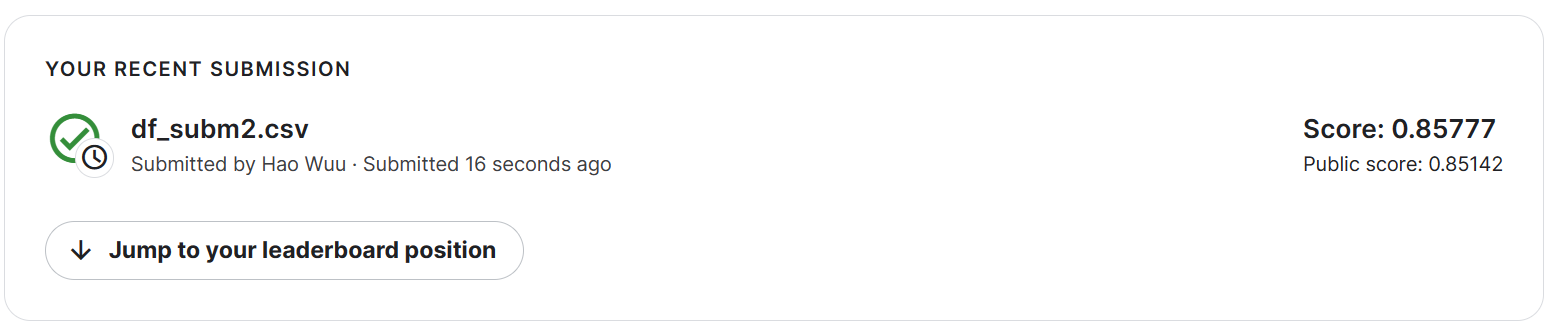

**It is much better than the first submission**

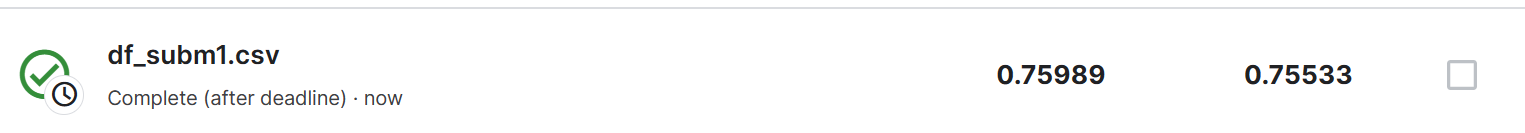